# Zadanie 1: Mnożenie macierzy
- Jakub Karbowski
- Jakub Szymczak

## Metoda rekurencyjna Binet'a

Polega na podziale macierzy na 4 równe bloki i rekurencyjnym wywoływaniu aż do przypadku granicznego, którym jest mnożenie skalarów.

$$
A = \left(
\begin{matrix}
A_{11} & A_{12} \\
A_{21} & A_{22}
\end{matrix}
\right)
,
B = \left(
\begin{matrix}
B_{11} & B_{12} \\
B_{21} & B_{22}
\end{matrix}
\right)
,
C = \left(
\begin{matrix}
C_{11} & C_{12} \\
C_{21} & C_{22}
\end{matrix}
\right)
$$

$$
\left(
\begin{matrix}
C_{11} & C_{12} \\
C_{21} & C_{22}
\end{matrix}
\right)
=
\left(
\begin{matrix}
A_{11} & A_{12} \\
A_{21} & A_{22}
\end{matrix}
\right)
\left(
\begin{matrix}
B_{11} & B_{12} \\
B_{21} & B_{22}
\end{matrix}
\right)
=
\left(
\begin{matrix}
A_{11} B_{11} + A_{12} B_{12} & A_{11} B_{12} + A_{12} B_{22} \\
A_{21} B_{11} + A_{22} B_{21} & A_{21} B_{12} + A_{22} B_{22}
\end{matrix}
\right)
$$

```python
def binet_mul(a: Mat, b: Mat) -> Mat:
    assert len(a) == len(a[0]) == len(b) == len(b[0])
    n = len(a)

    if n == 1:
        # base case scalar multiplication
        return [[a[0][0] * b[0][0]]]
    else:
        assert n % 2 == 0
        # block size
        m = n // 2
        
        # input blocks
        a11 = mat_slice(a, 0, m, 0, m)
        a12 = mat_slice(a, 0, m, m, n)
        a21 = mat_slice(a, m, n, 0, m)
        a22 = mat_slice(a, m, n, m, n)

        b11 = mat_slice(b, 0, m, 0, m)
        b12 = mat_slice(b, 0, m, m, n)
        b21 = mat_slice(b, m, n, 0, m)
        b22 = mat_slice(b, m, n, m, n)

        # recursive calls
        c11 = mat_add(binet_mul(a11, b11), binet_mul(a12, b21))
        c12 = mat_add(binet_mul(a11, b12), binet_mul(a12, b22))
        c21 = mat_add(binet_mul(a21, b11), binet_mul(a22, b21))
        c22 = mat_add(binet_mul(a21, b12), binet_mul(a22, b22))

        # combine blocks
        c = mat_zeros(n, n)
        for i in range(m):
            for j in range(m):
                c[i][j] = c11[i][j]
                c[i][j + m] = c12[i][j]
                c[i + m][j] = c21[i][j]
                c[i + m][j + m] = c22[i][j]

        return c
```

### Wydajność

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('binet.csv')

Zmierzono liczbę operacji zmiennoprzecinkowych `+ *` w zależności od rozmiaru macierzy.
Do pomiarów wpasowano wielomian $y=ax^3$.

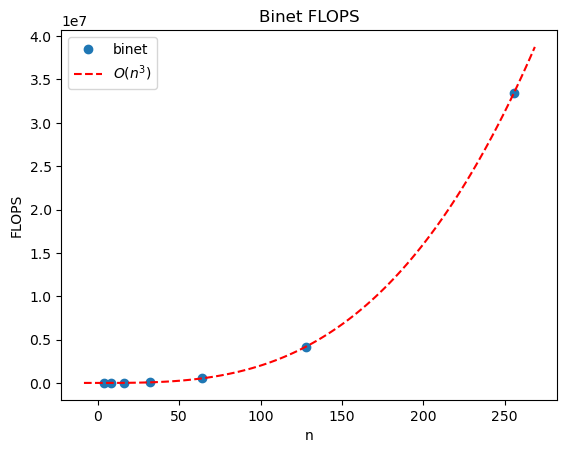

In [77]:
plt.plot(df['n'], df['flops_binet'], 'o', label='binet')

x = df['n']
y = df['flops_binet']
p = np.polyfit(x, y, 3)
p[1:] = 0
x = np.linspace(*plt.xlim(), 100)
plt.plot(x, np.polyval(p, x), 'r--', label='$O(n^3)$')

plt.legend()
plt.title('Binet FLOPS')
plt.xlabel('n')
plt.ylabel('FLOPS')
plt.show()

Zmierzono również czas, który został porównany z implementacją `numpy.matmul`.

/var/folders/sd/yrr8ypm52gv1wbxvgg_8f1b40000gn/T/ipykernel_21371/3762522458.py:21: RuntimeWarning: invalid value encountered in power
  return a * x**b


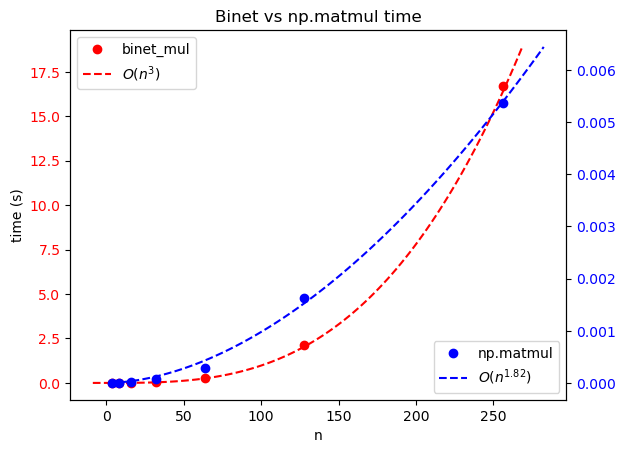

In [78]:
import scipy.optimize

fig, ax1 = plt.subplots()
ax1.set_xlabel('n')
ax1.set_ylabel('time (s)')
ax1.tick_params(axis='y', labelcolor='red')
ax1.plot(df['n'], df['time_binet'], 'o', label='binet_mul', color='red')

x = df['n']
y = df['time_binet']
p = np.polyfit(x, y, 3)
p[1:] = 0
x = np.linspace(*plt.xlim(), 100)
ax1.plot(x, np.polyval(p, x), 'r--', label='$O(n^3)$')

ax2 = ax1.twinx()
ax2.tick_params(axis='y', labelcolor='blue')
ax2.plot(df['n'], df['time_np'], 'o', label='np.matmul', color='blue')

def f(x, a, b):
    return a * x**b

x = df['n'].astype(np.float64)
y = df['time_np'].astype(np.float64)
popt, pcov = scipy.optimize.curve_fit(f, x, y, bounds=([1e-10, 1.1], [1e-1, 3]), p0=[1e-2, 2])
x = np.linspace(*plt.xlim(), 100)
ax2.plot(x, f(x, *popt), 'b--', label=f'$O(n^{{{popt[1]:.2f}}})$')

ax1.legend()
ax2.legend(loc='lower right')
plt.title('Binet vs np.matmul time')
plt.show()

Algorytm Binet'a ma złożoność $O(n^3)$, a algorytm stosowany w `numpy` ma mniejszą złożoność.
Do pomiarów czasów `numpy` została wpasowana złożoność $O(n^{1.82})$, co wydaje się błędne.
Może to być efekt stosowanych heurystyk lub po prostu błąd pomiaru czasu.

## Metoda Strassen'a